In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import torch
import transformers
from transformers import AutoTokenizer,AutoModelForSequenceClassification
import re

In [25]:
df = pd.read_csv(r'/content/sentiment_dataset.csv')

In [26]:
df.columns

Index(['id', 'text', 'label', 'sentiment'], dtype='object')

In [27]:
df.head()

,id,text,label,sentiment
0,0,"Cooking microwave pizzas, yummy",2,positive
1,1,Any plans of allowing sub tasks to show up in ...,1,neutral
2,2,"I love the humor, I just reworded it. Like sa...",2,positive
3,3,naw idk what ur talkin about,1,neutral
4,4,That sucks to hear. I hate days like that,0,negative


In [28]:
df['text']

,text
0,"Cooking microwave pizzas, yummy"
1,Any plans of allowing sub tasks to show up in ...
2,"I love the humor, I just reworded it. Like sa..."
3,naw idk what ur talkin about
4,That sucks to hear. I hate days like that
...,...
31227,Grrrr....I got the wrong size coat for the sheep
31228,4 cases of swine flu!
31229,excellent
31230,is sitting thru the boring bits in Titanic wai...


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31232 entries, 0 to 31231
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         31232 non-null  int64 
 1   text       31232 non-null  object
 2   label      31232 non-null  int64 
 3   sentiment  31232 non-null  object
dtypes: int64(2), object(2)
memory usage: 976.1+ KB


In [30]:
def pre_process(data):
    df = data.lower()
    return df

In [31]:
import string as str
def remove_specichar(data):
    symbols = {'~', ':', "'", '+', '[', '\\', '@', '^', '{', '%', '(', '-', '"', '*', '|', ',', '&', '<', '`', '}', '.', '_', '=', ']', '!', '>', ';', '?', '#', '$', ')', '/'}
    for i in data:
        print(i)
        if i in symbols:
            df = data.replace(i,'')

            return df

In [32]:
import re
def sep_rem(data):
    df = re.sub(r"[^a-zA-Z0-9]"," ",data)
    df1 = re.sub(r"[-()\"#/@;:<>{}/''`+=~|.!?,]", " ", df)
    return df1

In [33]:
df['clean'] = df['text'].apply(lambda x:pre_process(x))

In [34]:
df['clean'][0]

'cooking microwave pizzas, yummy'

In [35]:
df['cleansp']= df['clean'].apply(lambda x:sep_rem(x))

In [36]:
df['cleansp'][0]

'cooking microwave pizzas  yummy'

In [37]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,11649
positive,10478
negative,9105


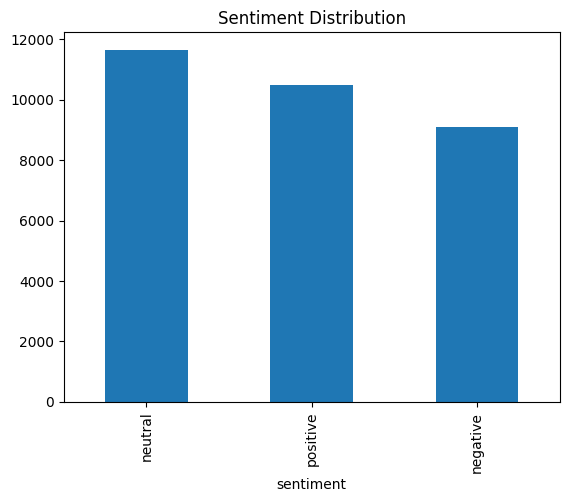

In [38]:
import matplotlib.pyplot as plt

df['sentiment'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.show()

In [39]:
df['text_length'] = df['text'].apply(len)
df['text_length'].describe()

,text_length
count,31232.000000
mean,95.988730
std,95.088851
min,1.000000
25%,41.000000
50%,72.000000
75%,115.000000
max,2176.000000


In [40]:
X = df['clean']
y = df['label']

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [42]:
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

,proportion
label,
1,0.372979
2,0.335521
0,0.291500


In [43]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [44]:
import numpy as np
from collections import Counter
def build_vocab(texts, max_words=10000):
    words = []
    _builtin_str = __builtins__.str # Reference to built-in str
    for text in texts:
        words.extend(_builtin_str(text).split())

    vocab = ['<PAD>', '<UNK>'] + [
        w for w, _ in Counter(words).most_common(max_words - 2)
    ]

    return {w: i for i, w in enumerate(vocab)}
word_to_idx = build_vocab(X_train, max_words=10000)
vocab_size = len(word_to_idx)

print("Vocabulary size:", vocab_size)
def text_to_indices(texts, word_to_idx, max_len=100):
    data = []
    _builtin_str = __builtins__.str # Reference to built-in str
    for text in texts:
        seq = [
            word_to_idx.get(word, word_to_idx['<UNK>'])
            for word in _builtin_str(text).split()[:max_len]
        ]

        seq += [word_to_idx['<PAD>']] * (max_len - len(seq))
        data.append(seq)

    return np.array(data)
max_len = 100

X_train_idx = text_to_indices(X_train, word_to_idx, max_len)
X_test_idx  = text_to_indices(X_test,  word_to_idx, max_len)

y_train_np = np.array(y_train)
y_test_np  = np.array(y_test)

print("Train shape:", X_train_idx.shape)
print("Test shape:", X_test_idx.shape)

Vocabulary size: 10000
Train shape: (24985, 100)
Test shape: (6247, 100)


In [45]:
import torch
from torch.utils.data import TensorDataset, DataLoader
X_train_tensor = torch.tensor(X_train_idx, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_idx, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)


In [46]:
print("Training batches:", len(train_loader))
print("Test batches:", len(test_loader))


Training batches: 391
Test batches: 98


In [47]:
import torch
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=128, num_classes=3, dropout=0.5):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        h = torch.cat((h[-2], h[-1]), dim=1)
        x = self.dropout(h)
        return self.fc(x)

# Initialize model
vocab_size = len(word_to_idx)
model = SimpleLSTM(vocab_size).to(device)

# Print model info
print(model)
print("Total parameters:", sum(p.numel() for p in model.parameters()))


SimpleLSTM(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)
Total parameters: 1236291


In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, n_filters=100, filter_sizes=(3,4,5), num_classes=3, dropout=0.5):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.convs = nn.ModuleList([
            nn.Conv2d(1, n_filters, (fs, embed_dim))
            for fs in filter_sizes
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(filter_sizes) * n_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [torch.max(c, dim=2)[0] for c in x]
        x = self.dropout(torch.cat(x, dim=1))
        return self.fc(x)

# Initialize model
cnn_model = TextCNN(vocab_size=len(word_to_idx)).to(device)

# Print model info
print(cnn_model)
print("Total parameters:", sum(p.numel() for p in cnn_model.parameters()))


TextCNN(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=300, out_features=3, bias=True)
)
Total parameters: 1121203


In [49]:
import torch
import torch.nn as nn

class SimpleMLP(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=256, num_classes=3, dropout=0.5):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x).mean(dim=1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        return self.fc3(x)

# Initialize model
mlp_model = SimpleMLP(vocab_size=len(word_to_idx)).to(device)

# Print model info
print(mlp_model)
print("Total parameters:", sum(p.numel() for p in mlp_model.parameters()))


SimpleMLP(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)
Total parameters: 1059139


In [50]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def train_model(model, train_loader, test_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        # -------- Training --------
        model.train()
        correct, total, train_loss = 0, 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accs.append(correct / total)

        # -------- Testing --------
        model.eval()
        correct, total, test_loss = 0, 0, 0

        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)

                test_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        test_losses.append(test_loss / len(test_loader))
        test_accs.append(correct / total)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Acc: {train_accs[-1]:.4f} | "
              f"Test Acc: {test_accs[-1]:.4f}")

    return train_losses, test_losses, train_accs, test_accs


def plot_history(train_losses, test_losses, train_accs, test_accs):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1,2,2)
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(test_accs, label="Test Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.show()


In [51]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.numpy())

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"\nTest Accuracy: {acc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(
        all_labels, all_preds,
        target_names=["Negative", "Neutral", "Positive"]
    ))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["Negative", "Neutral", "Positive"],
        yticklabels=["Negative", "Neutral", "Positive"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return acc, all_preds, all_labels



TRAINING ALL MODELS

----------------------------------------
TRAINING LSTM
----------------------------------------
Epoch 1/5 | Train Acc: 0.4879 | Test Acc: 0.5518
Epoch 2/5 | Train Acc: 0.5908 | Test Acc: 0.6051
Epoch 3/5 | Train Acc: 0.6629 | Test Acc: 0.6245
Epoch 4/5 | Train Acc: 0.7101 | Test Acc: 0.6342
Epoch 5/5 | Train Acc: 0.7470 | Test Acc: 0.6437


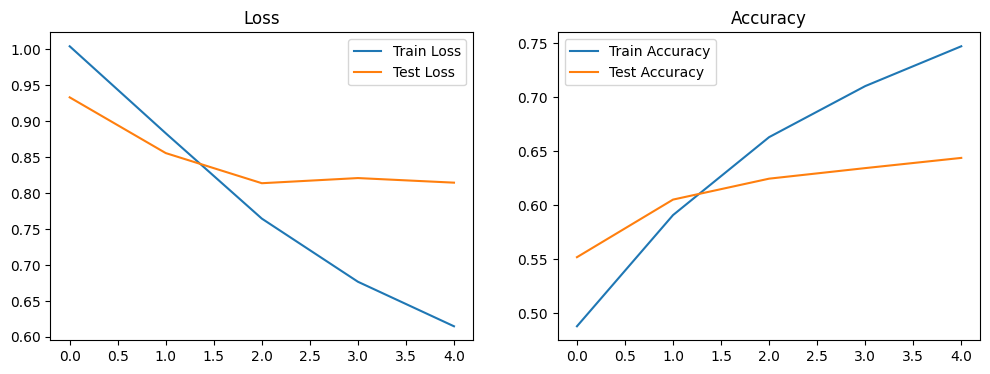


----------------------------------------
TRAINING CNN
----------------------------------------
Epoch 1/5 | Train Acc: 0.4622 | Test Acc: 0.5353
Epoch 2/5 | Train Acc: 0.5726 | Test Acc: 0.5905
Epoch 3/5 | Train Acc: 0.6313 | Test Acc: 0.6121
Epoch 4/5 | Train Acc: 0.6676 | Test Acc: 0.6323
Epoch 5/5 | Train Acc: 0.7040 | Test Acc: 0.6390


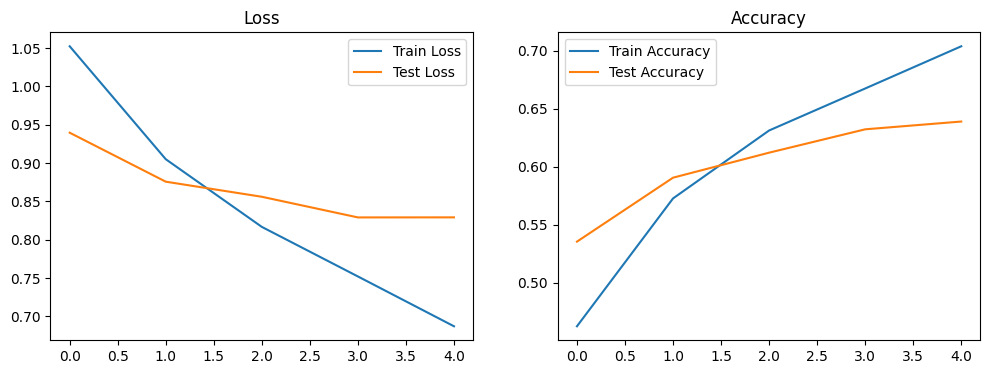


----------------------------------------
TRAINING MLP
----------------------------------------
Epoch 1/5 | Train Acc: 0.4460 | Test Acc: 0.5479
Epoch 2/5 | Train Acc: 0.5861 | Test Acc: 0.6028
Epoch 3/5 | Train Acc: 0.6439 | Test Acc: 0.6321
Epoch 4/5 | Train Acc: 0.6849 | Test Acc: 0.6433
Epoch 5/5 | Train Acc: 0.7135 | Test Acc: 0.6437


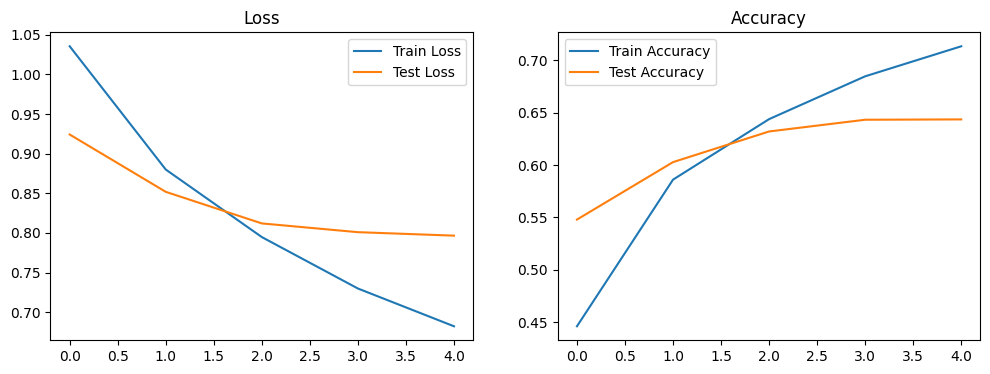


FINAL TEST ACCURACIES
LSTM: Test Accuracy = 0.6437
CNN: Test Accuracy = 0.6390
MLP: Test Accuracy = 0.6437


In [52]:
print("\n" + "="*60)
print("TRAINING ALL MODELS")
print("="*60)

models = {
    "LSTM": SimpleLSTM(vocab_size=len(word_to_idx)).to(device),
    "CNN": TextCNN(vocab_size=len(word_to_idx)).to(device),
    "MLP": SimpleMLP(vocab_size=len(word_to_idx)).to(device)
}

results = {}

for name, model in models.items():
    print("\n" + "-"*40)
    print(f"TRAINING {name}")
    print("-"*40)

    train_losses, test_losses, train_accs, test_accs = train_model(
        model,
        train_loader,
        test_loader,
        epochs=5,
        lr=0.001
    )

    plot_history(train_losses, test_losses, train_accs, test_accs)

    results[name] = {
        "model": model,
        "train_acc": train_accs[-1],
        "test_acc": test_accs[-1]
    }

print("\n" + "="*60)
print("FINAL TEST ACCURACIES")
print("="*60)

for name, res in results.items():
    print(f"{name}: Test Accuracy = {res['test_acc']:.4f}")


In [53]:
import torch
import pickle

# Determine best model based on test accuracy
best_model_name = max(results, key=lambda x: results[x]["test_acc"])
best_accuracy = results[best_model_name]["test_acc"]
best_model = results[best_model_name]["model"]

print(f"\nBest model: {best_model_name} with accuracy: {best_accuracy:.4f}")

# Save the best model
model_path = f"best_{best_model_name.lower()}_model.pth"
torch.save(best_model.state_dict(), model_path)
print(f"Saved best model as '{model_path}'")

# Save vocabulary
with open("vocab.pkl", "wb") as f:
    pickle.dump(word_to_idx, f)

print("Saved vocabulary as 'vocab.pkl'")



Best model: LSTM with accuracy: 0.6437
Saved best model as 'best_lstm_model.pth'
Saved vocabulary as 'vocab.pkl'


Test accuracy: 64.37%
Misclassified samples: 2226


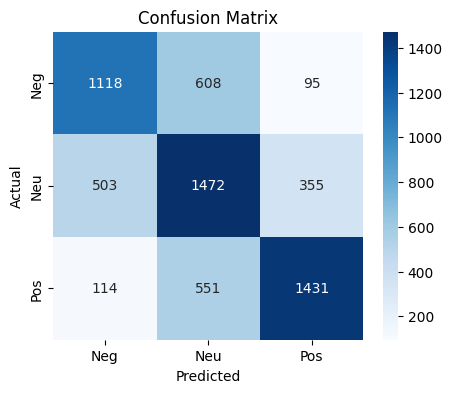


Sample misclassified texts:
----------------------------------------
Text:  i walk to & from work...about 25 mins...think that makes it worse   improves once indoors tho.
Actual: Neu
Predicted: Neg
----------------------------------------
Text: trying to decide on a movie with the friends.. not going to well! lol :p  no bible study 2nite, whic
Actual: Neg
Predicted: Neu
----------------------------------------
Text: if time tracking was added and the parser/interface of the "what would you like to do?" field was fi
Actual: Neu
Predicted: Pos
----------------------------------------
Text: pretty bummed that it had to rain last nite! oh well  still had fun! goldfish is highly overrated!
Actual: Neu
Predicted: Pos
----------------------------------------
Text: dammit.  i need new cupcake tins
Actual: Neg
Predicted: Neu


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
model.eval()
preds, labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        preds.extend(out.argmax(1).cpu().numpy())
        labels.extend(y.numpy())

preds = np.array(preds)
labels = np.array(labels)

# Accuracy & errors
errors = preds != labels
print(f"Test accuracy: {(~errors).mean()*100:.2f}%")
print(f"Misclassified samples: {errors.sum()}")

# Confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Neg", "Neu", "Pos"],
    yticklabels=["Neg", "Neu", "Pos"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Show a few misclassified examples
print("\nSample misclassified texts:")
idxs = np.where(errors)[0][:5]

for i in idxs:
    print("-"*40)
    # Corrected line: Use .iloc to access by positional index
    print("Text:", X_test.iloc[i][:100])
    print("Actual:", ["Neg","Neu","Pos"][labels[i]])
    print("Predicted:", ["Neg","Neu","Pos"][preds[i]])


In [55]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score

tokenizer = AutoTokenizer.from_pretrained(
    "nlptown/bert-base-multilingual-uncased-sentiment"
)
bert_model = AutoModelForSequenceClassification.from_pretrained(
    "nlptown/bert-base-multilingual-uncased-sentiment"
).to(device)

bert_model.eval()

def bert_predict(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = bert_model(**inputs)
        stars = outputs.logits.argmax(dim=1).item() + 1

    if stars <= 2:
        return 0   # Negative
    elif stars == 3:
        return 1   # Neutral
    else:
        return 2   # Positive

# Apply to subset
bert_preds = X_test[:5000].apply(bert_predict)

bert_accuracy = accuracy_score(y_test[:5000], bert_preds)
print(f"BERT accuracy (Q8): {bert_accuracy:.4f}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BERT accuracy (Q8): 0.5788
